In [21]:
import pandas as pd
import numpy as np
import seaborn as sns
import math

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,OrdinalEncoder
from sklearn.feature_selection import mutual_info_regression
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler,OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
import statsmodels as sm   # contains good statistical tools for modeling

from statsmodels.stats.outliers_influence import variance_inflation_factor  # we will need vif for checking multicollinearity
from sklearn.neighbors import LocalOutlierFactor

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.model_selection import learning_curve

from scipy.stats import zscore

import os, pickle, csv
from math import sqrt
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
plt.style.use('ggplot')

from IPython.display import HTML
import base64  


In [22]:
# from google.colab import files
uploaded = 'http://archive.ics.uci.edu/ml/machine-learning-databases/forest-fires/forestfires.csv'

In [23]:
df = pd.read_csv(uploaded)
columns = ['X','Y','month','day','FFMC','DMC','DC','ISI','temp','RH','wind','rain']

df[['day','month']] = OrdinalEncoder().fit_transform(df[['day','month']])

pd.DataFrame(data=[df.skew(),df.kurtosis()],index=['skewness','kurtosis'])

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
skewness,0.036246,0.417296,0.084074,0.157756,-6.575606,0.547498,-1.100445,2.536325,-0.331172,0.862904,0.571001,19.816344,12.846934
kurtosis,-1.172331,1.420553,-1.719350,-1.101004,67.066041,0.204822,-0.245244,21.458037,0.136166,0.438183,0.054324,421.295964,194.140721


In [24]:
df[columns]=StandardScaler().fit_transform(df[columns])

print(df.shape)
z = np.abs(zscore(df))
df = df[(z < 3).all(axis=1)]
print(df.shape)


(517, 13)
(486, 13)


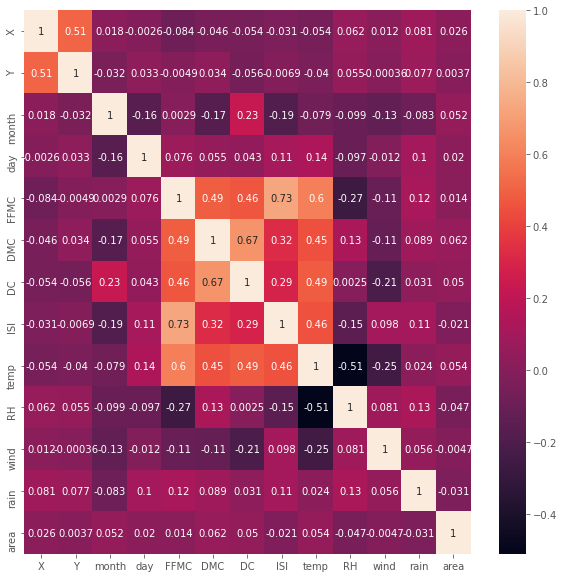

In [5]:
fig, ax = plt.subplots(figsize=(10,10))         # Sample figsize in inches
sns.heatmap(df.corr(),annot=True)

In [6]:
X1 = sm.tools.add_constant(df) 

series1 = pd.Series([variance_inflation_factor(X1.values,i) for i in range(X1.shape[1])],
                  index=X1.columns)

series1

const    1.334274
X        1.380336
Y        1.378691
month    1.567285
day      1.065657
FFMC     3.345243
DMC      2.745312
DC       2.721977
ISI      2.618092
temp     2.862027
RH       1.909193
wind     1.192008
rain     1.076656
area     1.016980
dtype: float64

All variance inflation factor coefficient are less than five, it can be concluded that there is no correlation between features.

In [7]:
numerical_features = df.drop(columns=['area']).copy()
print(numerical_features.columns)

Index(['X', 'Y', 'month', 'day', 'FFMC', 'DMC', 'DC', 'ISI', 'temp', 'RH',
       'wind', 'rain'],
      dtype='object')


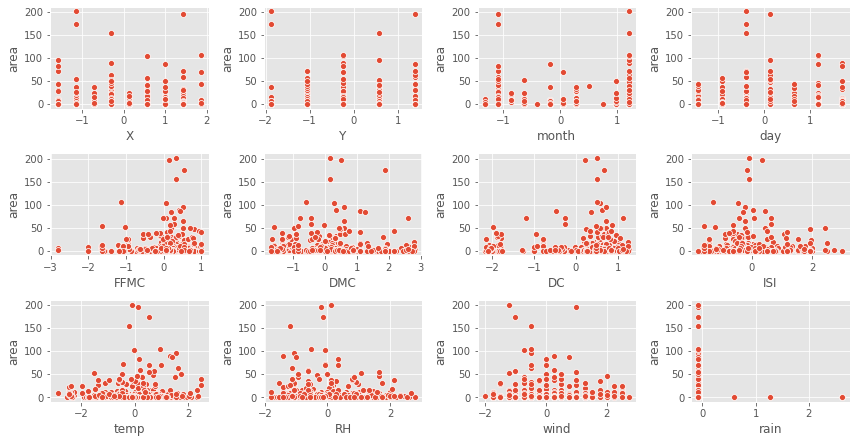

In [8]:
fig = plt.figure(figsize=(12,18))
for i in range(12):
    fig.add_subplot(9, 4, i+1)
    sns.scatterplot(numerical_features.iloc[:, i],df['area'])
plt.tight_layout()
plt.show()

In [9]:
df.skew()

X         0.063923
Y        -0.202949
month     0.052650
day       0.159875
FFMC     -1.685313
DMC       0.569870
DC       -1.190412
ISI       0.683740
temp     -0.328373
RH        0.706399
wind      0.486262
rain     13.349848
area      5.326617
dtype: float64

In [10]:
df.kurtosis() 

X         -1.172167
Y         -0.449995
month     -1.747641
day       -1.113485
FFMC       4.254761
DMC        0.282799
DC         0.011288
ISI        0.461803
temp       0.247071
RH        -0.005989
wind      -0.164352
rain     184.836192
area      35.472354
dtype: float64

In [11]:
df.describe()

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
count,486.000000,486.000000,486.000000,486.000000,486.000000,486.000000,486.000000,486.000000,486.000000,486.000000,486.000000,486.000000,486.000000
mean,-0.042953,-0.064818,0.016721,0.008394,0.090212,0.023017,0.041235,-0.007240,0.013679,-0.044691,-0.030526,-0.057958,8.233210
std,0.985553,0.910819,1.011503,1.005144,0.564407,0.993732,0.979924,0.856469,0.985249,0.937818,0.970576,0.186201,21.978126
min,-1.587360,-1.871724,-1.317959,-1.423121,-2.818736,-1.685913,-2.179108,-1.739089,-2.876943,-1.796637,-2.021098,-0.073268,0.000000
25%,-0.722136,-0.244001,-1.089076,-0.903154,-0.062501,-0.555952,-0.294723,-0.526153,-0.532523,-0.753800,-0.736124,-0.073268,0.000000
50%,-0.289524,-0.244001,0.055339,0.136781,0.182296,-0.038640,0.474768,-0.136477,0.070821,-0.201709,-0.009834,-0.073268,0.530000
75%,0.575701,0.569860,1.199754,0.656748,0.408960,0.492739,0.674505,0.368455,0.674164,0.534411,0.492982,-0.073268,6.515000
max,1.873537,1.383722,1.199754,1.696682,1.007353,2.819865,1.261610,2.980931,2.484195,2.804116,2.727720,2.632426,200.940000


In [25]:
X = df.drop(columns=['area'])
y = df['area'].to_numpy()

In [26]:
outliers = LocalOutlierFactor(n_neighbors=20).fit_predict(X)

target_out = LocalOutlierFactor(n_neighbors=20).fit_predict(y.reshape(-1, 1))

outliers = outliers == 1
target_out = target_out == 1
for i,t in enumerate(target_out):
  outliers[i]=outliers[i] and t


X,y=X[outliers],y[outliers]
X_2,y_2=X,y
X_3=X


print(X.shape)
y.shape

(468, 12)


(468,)

In [7]:
import requests


url_linreg = 'https://raw.githubusercontent.com/ankonzoid/LearningX/master/advanced_ML/model_tree/models/linear_regr.py'
url_modeltree='https://raw.githubusercontent.com/ankonzoid/LearningX/master/advanced_ML/model_tree/src/ModelTree.py'

r = requests.get(url_linreg, allow_redirects=True)
with open('linear_regr.py', 'wb') as file:
  file.write(r.content)

r = requests.get(url_modeltree, allow_redirects=True)
with open('ModelTree.py', 'wb') as file:
  file.write(r.content)


# from google.colab import files
# uploaded = files.upload()

In [8]:
from ModelTree import ModelTree
from linear_regr import linear_regr

In [9]:
model = linear_regr()
model_tree = ModelTree(model, max_depth=2, min_samples_leaf=30,
                        search_type="greedy", n_search_grid=100)

In [10]:
cv_sets = KFold(n_splits=10, shuffle= True,random_state=100)
param_grid = {
              "max_depth": [1,2,3,4,5,6,7,8,9],
              "min_samples_leaf":[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25],
              # "search_type": ["greedy", "grid", "adaptive"],
              # "n_search_grid": [50,100,200]
              }

In [11]:
error_metric='neg_mean_absolute_error'

In [19]:
grid = GridSearchCV(model_tree, param_grid,cv=cv_sets,n_jobs=4,scoring=error_metric)

In [20]:
try:
  X=X.to_numpy()
except:
  print('X is already numpy')

try:
  y=y.to_numpy()
except:
  print('y is already numpy')

grid = grid.fit(X,y)
print("Best Hyperparameters::\n{}".format(grid.best_estimator_))
X.shape


y is already numpy
Best Hyperparameters::
ModelTree(model=<linear_regr.linear_regr object at 0x00000192FD241460>, max_depth=1, min_samples_leaf=24, search_type=greedy, n_search_grid=100)


(468, 12)

In [21]:
lmt_t = grid.best_estimator_


In [22]:
df = pd.DataFrame(data=grid.cv_results_)
df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_min_samples_leaf,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,9.976147,0.380618,0.004587,0.000662,1,1,"{'max_depth': 1, 'min_samples_leaf': 1}",-8.408774,-7.059410,-9.162449,-7.705382,-6.706521,-7.754087,-310.737296,-8.180974,-7.368467,-6.653363,-37.973672,90.924215,124
1,11.830890,0.783298,0.005884,0.000537,1,2,"{'max_depth': 1, 'min_samples_leaf': 2}",-8.408774,-7.059410,-9.162449,-7.705382,-6.706521,-7.754087,-310.737296,-8.180974,-7.368467,-6.653363,-37.973672,90.924215,124
2,12.377230,0.283042,0.005784,0.000598,1,3,"{'max_depth': 1, 'min_samples_leaf': 3}",-8.408774,-7.059410,-9.162449,-7.705382,-6.706521,-7.754087,-310.737296,-8.180974,-7.368467,-6.653363,-37.973672,90.924215,124
3,11.730050,0.764019,0.005884,0.000829,1,4,"{'max_depth': 1, 'min_samples_leaf': 4}",-8.408774,-7.059410,-9.162449,-7.705382,-6.706521,-7.754087,-310.737296,-8.180974,-7.368467,-6.653363,-37.973672,90.924215,124
4,10.938259,0.305481,0.005485,0.000498,1,5,"{'max_depth': 1, 'min_samples_leaf': 5}",-8.408774,-7.059410,-9.162449,-7.705382,-6.706521,-7.754087,-310.737296,-8.180974,-7.368467,-6.653363,-37.973672,90.924215,124
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
220,61.976546,3.415788,0.006682,0.000898,9,21,"{'max_depth': 9, 'min_samples_leaf': 21}",-12.706097,-15.621176,-12.566656,-19.152827,-10.530869,-10.894931,-9.569458,-10.722595,-10.728225,-11.419934,-12.391277,2.764729,91
221,61.305560,4.041636,0.006582,0.000488,9,22,"{'max_depth': 9, 'min_samples_leaf': 22}",-12.099665,-16.196886,-12.042788,-17.404256,-10.322538,-11.404597,-10.073229,-12.597787,-10.107544,-12.704070,-12.495336,2.359943,92
222,53.636533,4.392737,0.006084,0.000698,9,23,"{'max_depth': 9, 'min_samples_leaf': 23}",-12.099665,-15.858373,-11.985736,-16.760816,-10.132128,-10.130248,-9.367463,-12.296548,-10.914125,-12.704070,-12.224917,2.296402,89
223,51.654630,3.764801,0.006084,0.000537,9,24,"{'max_depth': 9, 'min_samples_leaf': 24}",-12.099665,-15.027687,-11.485975,-16.760816,-10.063743,-10.027267,-9.195016,-13.971001,-10.735381,-12.832751,-12.219930,2.308874,88


[Text(0.5, 1.0, 'Effect of Depth and Leaf Nodes on Model Performance')]

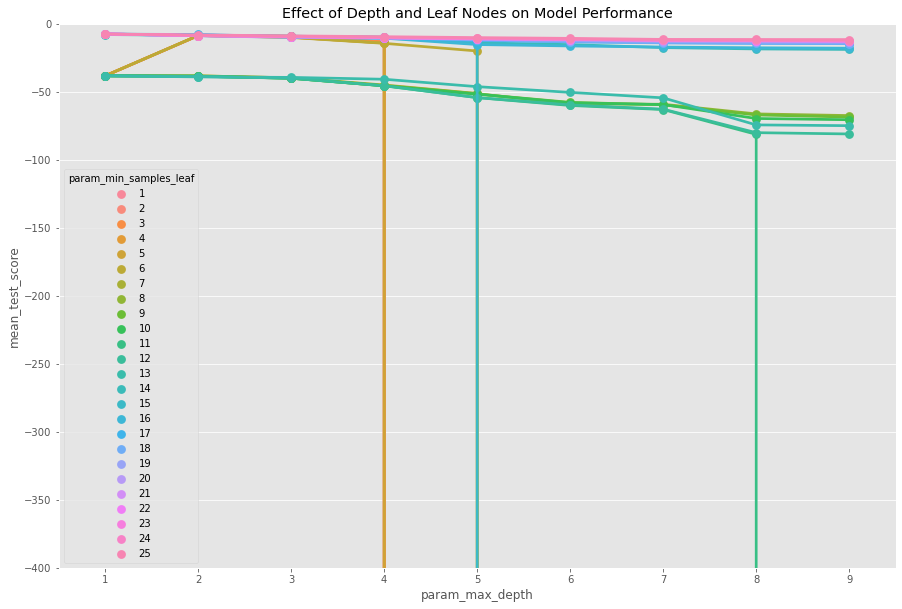

In [30]:
fig,ax = plt.subplots(figsize=(15,10))
ax.set_ylim([-400,0])
sns.pointplot(data=df[['mean_test_score',
                           'param_min_samples_leaf',
                           'param_max_depth']],
             y='mean_test_score',x='param_max_depth',
             hue='param_min_samples_leaf',ax=ax)
ax.set(title="Effect of Depth and Leaf Nodes on Model Performance")

In [28]:
folds = KFold(n_splits = 10, shuffle = True, random_state = 100)

In [ ]:
def get_soc(D,f):
    return (2*D+1)+(2*f)  

In [26]:
print(X.shape)
# X=X.to_numpy()
# print(mean_squared_error(y,y_pred))
mse = cross_val_score(lmt_t,X,y,cv=folds,scoring='neg_mean_squared_error')
mse=np.abs(np.mean(mse))
print("Mean Squared Error: {}".format(mse))
rmse=math.sqrt(mse)
print("Root Mean Squared Error: {}".format(rmse))
mae = cross_val_score(lmt_t,X,y,cv=folds,scoring='neg_mean_absolute_error')
mae = np.abs(np.mean(mae))
print("mean absolute error: {}".format(mae))
r2 = cross_val_score(lmt_t,X,y,cv=folds,scoring='r2')
r2 = np.abs(np.mean(r2))
print("Overall model accuracy: {}".format(r2))
soc=get_soc(lmt_t.max_depth,X.shape[1])
print("SOC: {}".format(soc))

(468, 12)
Mean Squared Error: 126.22162409739526
Root Mean Squared Error: 11.234839745069587
mean absolute error: 7.180221071008512
Overall model accuracy: 0.24903208007966188
SOC: 27


In [51]:
train_sizes=np.array([0.1,0.2,0.3,0.4,0.5,1.0])
_,train_scores,validation_scores=learning_curve(lmt_t,X,y,cv=folds,train_sizes=train_sizes,scoring=error_metric)

In [52]:
train_scores_mean = -train_scores.mean(axis = 1)
validation_scores_mean = -validation_scores.mean(axis = 1)


Mean training scores

 0.1   -0.000000
0.2   -0.000000
0.3    0.084955
0.4    1.443308
0.5    5.683612
1.0    6.287324
dtype: float64

 --------------------

Mean validation scores

 0.1    5.204963
0.2    5.204963
0.3    5.226166
0.4    5.633059
0.5    8.116995
1.0    7.181195
dtype: float64


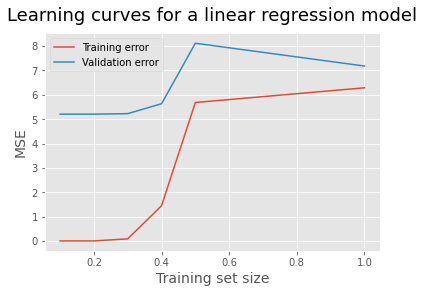

In [53]:
plt.title("Learning curve")

plt.plot(train_sizes, train_scores_mean, label = 'Training error')
plt.plot(train_sizes, validation_scores_mean, label = 'Validation error')
plt.legend()
plt.ylabel('MSE', fontsize = 14)
plt.xlabel('Training set size', fontsize = 14)
plt.title('Learning curves for a linear regression model', fontsize = 18, y = 1.03)
plt.legend()

In [113]:
mses = []
SOCs = []
arr_maes = []
max_depth = []
leaves = []
print(X.shape)
# X=X.to_numpy()
# y=y.to_numpy()
for x in range(1,8):
  cv_sets = KFold(n_splits=10, shuffle= True,random_state=100)
  param_grid = {
                "max_depth": [x],
                "min_samples_leaf": [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25],
#                 "search_type": ["greedy", "grid", "adaptive"],
#                 "n_search_grid": [50,100,200]
  }  
  grid = GridSearchCV(model_tree, param_grid,cv=cv_sets,n_jobs=4,scoring=error_metric)
  grid = grid.fit(X, y)
  print("Best Hyperparameters::\n{}".format(grid.best_estimator_))
  lmt = grid.best_estimator_
  mse = cross_val_score(lmt,X,y,cv=cv_sets,scoring='neg_mean_squared_error')
  mae = cross_val_score(lmt,X,y,cv=cv_sets,scoring='neg_mean_absolute_error')

  mse=np.abs(np.mean(mse))
  mses.append(mse)
  mae=np.abs(np.mean(mae))
  arr_maes.append(mae)
  soc=get_soc(x,X.shape[1])
  SOCs.append(soc)
  max_depth.append(x)
print(SOCs);
mses

(468, 12)
Best Hyperparameters::
ModelTree(model=<linear_regr.linear_regr object at 0x00000192FCE03100>, max_depth=1, min_samples_leaf=24, search_type=greedy, n_search_grid=100)
Best Hyperparameters::
ModelTree(model=<linear_regr.linear_regr object at 0x00000192FA5BADF0>, max_depth=2, min_samples_leaf=17, search_type=greedy, n_search_grid=100)
Best Hyperparameters::
ModelTree(model=<linear_regr.linear_regr object at 0x00000192FCE08AC0>, max_depth=3, min_samples_leaf=25, search_type=greedy, n_search_grid=100)
Best Hyperparameters::
ModelTree(model=<linear_regr.linear_regr object at 0x00000192FCE08130>, max_depth=4, min_samples_leaf=25, search_type=greedy, n_search_grid=100)
Best Hyperparameters::
ModelTree(model=<linear_regr.linear_regr object at 0x00000192FEE0B3A0>, max_depth=5, min_samples_leaf=25, search_type=greedy, n_search_grid=100)
Best Hyperparameters::
ModelTree(model=<linear_regr.linear_regr object at 0x00000192FEE27940>, max_depth=6, min_samples_leaf=25, search_type=greedy, n

[126.22162409739526,
 141.72205210622639,
 164.46652022233562,
 189.88047280580815,
 218.084625562222,
 237.96076735402985,
 291.53369131154227]

In [114]:
min_samples_leaf=[24,17,25,25,25,25,25]
arr_maes

[7.180221071008512,
 7.55907455901545,
 8.58333716990818,
 9.182974542677872,
 9.855422687653002,
 10.412304513715068,
 11.188675384275719]

In [14]:
msses=[]
arrr_maes=[]
SOCCs=[]
max_d=[]
ml=[]

In [17]:
try:
  X=X.to_numpy()
except:
  print('X is already numpy')

try:
  y=y.to_numpy()
except:
  print('y is already numpy')
for x in range(14,23,2):
    for y in range(1,3):
      LMT = ModelTree(model, max_depth=y, min_samples_leaf=x,
                              search_type="greedy", n_search_grid=100)
      mse = cross_val_score(LMT,X,y,cv=cv_sets,scoring='neg_mean_squared_error')
      mae = cross_val_score(LMT,X,y,cv=cv_sets,scoring='neg_mean_absolute_error')

      mse=np.abs(np.mean(mse))
      msses.append(mse)
      mae=np.abs(np.mean(mae))
      arrr_maes.append(mae)
      soc=get_soc(y,X.shape[1])
      SOCCs.append(soc)
      max_d.append(y)
      ml.append(x)

X is already numpy
y is already numpy


In [30]:
mses=[126.22162409739526,
 141.72205210622639,
 164.46652022233562,
 189.88047280580815,
 218.084625562222,
 237.96076735402985,
 291.53369131154227,
 219.51963924064466,168.26381549413097, 153.1812946032357, 211.0008227039869, 211.20020232590204, 158.38309375828985, 141.05711364412974, 128.2049523258906, 129.0663192295176, 129.08188642029876]
min_samples_leaf=[24, 17, 25, 25, 25, 25, 25, 14, 16,18,20,22,14, 16, 18, 20, 22]
SOCs=[27, 29, 31, 33, 35, 37, 39, 29, 29,29, 29, 29,27, 27, 27, 27, 27]
arr_maes=[7.180221071008512, 7.55907455901545, 8.58333716990818, 9.182974542677872, 9.855422687653002, 10.412304513715068, 11.188675384275719, 8.202726125385162, 7.88282265904378,7.9495299337227765, 8.364372652527432, 8.393245079051226,7.6325348173294, 7.310612557654847, 7.22477422019154, 7.198671566967647, 7.20625250999002]
max_depth=[1, 2, 3, 4, 5, 6, 7, 2, 2,2,2,2,1, 1, 1, 1, 1]
print(SOCs)
print(arr_maes)
print(max_depth)
print(mses)

[27, 29, 31, 33, 35, 37, 39, 29, 29, 29, 29, 29, 27, 27, 27, 27, 27]
[7.180221071008512, 7.55907455901545, 8.58333716990818, 9.182974542677872, 9.855422687653002, 10.412304513715068, 11.188675384275719, 8.202726125385162, 7.88282265904378, 7.9495299337227765, 8.364372652527432, 8.393245079051226, 7.6325348173294, 7.310612557654847, 7.22477422019154, 7.198671566967647, 7.20625250999002]
[1, 2, 3, 4, 5, 6, 7, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1]
[126.22162409739526, 141.72205210622639, 164.46652022233562, 189.88047280580815, 218.084625562222, 237.96076735402985, 291.53369131154227, 219.51963924064466, 168.26381549413097, 153.1812946032357, 211.0008227039869, 211.20020232590204, 158.38309375828985, 141.05711364412974, 128.2049523258906, 129.0663192295176, 129.08188642029876]


In [31]:
arr_mse_min = 126.221
arr_mae_min = min(arr_maes)
arr_soc_min = [27]
arr_mse_min_soc = 126.221
arr_mae_min_soc = min(arr_maes)
arr_soc_min_soc = [27]
print("Lowest Mean Squared Error: {}".format(arr_mse_min))
print("Lowest Mean Absolute Error: {}".format(arr_mae_min))

Lowest Mean Squared Error: 126.221
Lowest Mean Absolute Error: 7.180221071008512


In [32]:
arr_mse_not_allowed = [ x for x in mses if x >= arr_mse_min*1.1 ]
arr_mae_not_allowed = [ x for x in arr_maes if x >= arr_mae_min*1.1 ]
arr_mse_not_allowed, arr_mae_not_allowed

([141.72205210622639,
  164.46652022233562,
  189.88047280580815,
  218.084625562222,
  237.96076735402985,
  291.53369131154227,
  219.51963924064466,
  168.26381549413097,
  153.1812946032357,
  211.0008227039869,
  211.20020232590204,
  158.38309375828985,
  141.05711364412974],
 [8.58333716990818,
  9.182974542677872,
  9.855422687653002,
  10.412304513715068,
  11.188675384275719,
  8.202726125385162,
  7.9495299337227765,
  8.364372652527432,
  8.393245079051226])

In [24]:
arr_mse_not_allowed_soc = [29, 31, 33, 35, 37,39, 29,29,29,29,29,27,27,27]
arr_mae_not_allowed_soc = [31, 33, 35, 37,39, 29,29,29,29]

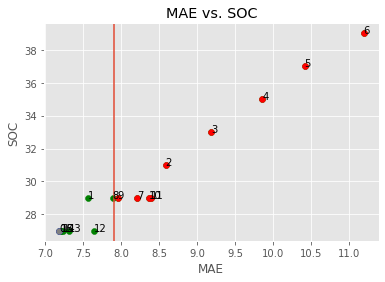

In [33]:
plt.title("MAE vs. SOC")

plt.scatter(arr_maes, SOCs, c='green')
plt.scatter(arr_mae_not_allowed, arr_mae_not_allowed_soc, c='red')
plt.scatter(arr_mae_min, arr_soc_min, c='blue')
plt.scatter(arr_mae_min_soc, arr_soc_min_soc, c='grey')
plt.axvline(x=arr_mae_min*1.1)
for i, txt in enumerate(mses):
    plt.annotate(i, (arr_maes[i], SOCs[i]))
plt.xlabel('MAE')
plt.ylabel('SOC')
plt.show()

In [34]:
data = { 'MSE': mses, 'MAE': arr_maes, 'SOC': SOCs, 'max_depth': max_depth,  'min_samples_leaf': min_samples_leaf }
df2 = pd.DataFrame(data)
df2


,MSE,MAE,SOC,max_depth,min_samples_leaf
0,126.221624,7.180221,27,1,24
1,141.722052,7.559075,29,2,17
2,164.466520,8.583337,31,3,25
3,189.880473,9.182975,33,4,25
4,218.084626,9.855423,35,5,25
5,237.960767,10.412305,37,6,25
6,291.533691,11.188675,39,7,25
7,219.519639,8.202726,29,2,14
8,168.263815,7.882823,29,2,16
9,153.181295,7.949530,29,2,18


In [95]:
df_header = df.columns.values  # header
header = list(df_header)
k=12
bestfeatures = SelectKBest(score_func=f_regression, k=k)
fit = bestfeatures.fit(X,y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(header)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns
print(featureScores.nlargest(k,'Score'))
col=featureScores.nlargest(k,'Score')
col=col.drop(['Score'], axis=1)


    Specs     Score
10   wind  2.665304
0       X  1.549705
11   rain  0.851719
3     day  0.637407
4    FFMC  0.523909
5     DMC  0.373371
2   month  0.337813
1       Y  0.300340
8    temp  0.128801
9      RH  0.080501
7     ISI  0.041118
6      DC  0.012693


y is already numpy
Best Hyperparameters::
ModelTree(model=<linear_regr.linear_regr object at 0x000001AFA11FDA60>, max_depth=1, min_samples_leaf=22, search_type=greedy, n_search_grid=100)
(468, 12)


NameError: name 'folds' is not defined

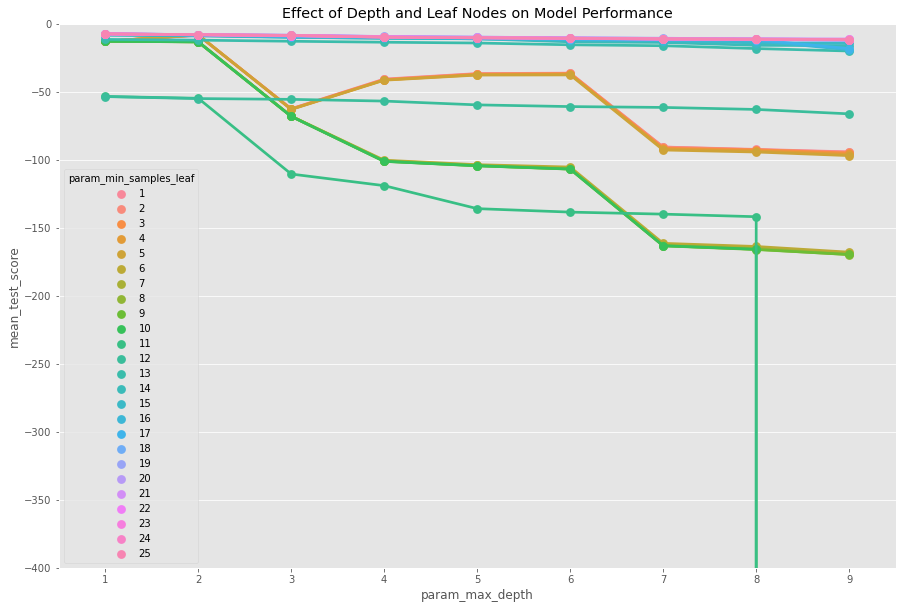

In [12]:
X_new=X_2.drop(['DC'], axis=1)

cv_sets = KFold(n_splits=10, shuffle= True,random_state=100)
param_grid = {
              "max_depth": [1,2,3,4,5,6,7,8,9],
              "min_samples_leaf":[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25],
              # "search_type": ["greedy", "grid", "adaptive"],
              # "n_search_grid": [50,100,200]
              }
grid = GridSearchCV(model_tree, param_grid,cv=cv_sets,n_jobs=4,scoring=error_metric)
try:
  X_new=X_new.to_numpy()
except:
  print('X is already numpy')

try:
  y=y.to_numpy()
except:
  print('y is already numpy')

grid = grid.fit(X_new,y)
print("Best Hyperparameters::\n{}".format(grid.best_estimator_))
lmt_t_2 = grid.best_estimator_
df = pd.DataFrame(data=grid.cv_results_)
fig,ax = plt.subplots(figsize=(15,10))
ax.set_ylim([-400,0])
sns.pointplot(data=df[['mean_test_score',
                           'param_min_samples_leaf',
                           'param_max_depth']],
             y='mean_test_score',x='param_max_depth',
             hue='param_min_samples_leaf',ax=ax)
ax.set(title="Effect of Depth and Leaf Nodes on Model Performance")




(468, 12)
mean absolute error: 6.99342640309518
SOC: 25


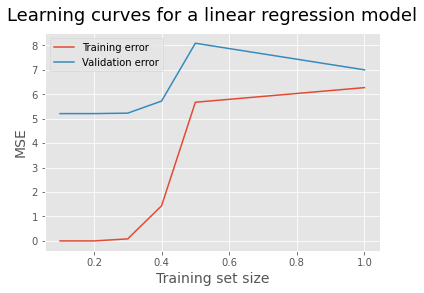

In [28]:
train_sizes=np.array([0.1,0.2,0.3,0.4,0.5,1.0])
_,train_scores,validation_scores=learning_curve(lmt_t_2,X_new,y,cv=cv_sets,train_sizes=train_sizes,scoring=error_metric)
train_scores_mean = -train_scores.mean(axis = 1)
validation_scores_mean = -validation_scores.mean(axis = 1)

plt.title("Learning curve")

plt.plot(train_sizes, train_scores_mean, label = 'Training error')
plt.plot(train_sizes, validation_scores_mean, label = 'Validation error')
plt.legend()
plt.ylabel('MSE', fontsize = 14)
plt.xlabel('Training set size', fontsize = 14)
plt.title('Learning curves for a linear regression model', fontsize = 18, y = 1.03)
plt.legend()
print(X.shape)
mae = cross_val_score(lmt_t_2,X_new,y,cv=cv_sets,scoring='neg_mean_absolute_error')
mae = np.abs(np.mean(mae))
print("mean absolute error: {}".format(mae))
soc=get_soc(lmt_t_2.max_depth,X_new.shape[1])
print("SOC: {}".format(soc))

(468, 10)
y is already numpy
Best Hyperparameters::
ModelTree(model=<linear_regr.linear_regr object at 0x000001AFA3420790>, max_depth=1, min_samples_leaf=16, search_type=greedy, n_search_grid=100)


[Text(0.5, 1.0, 'Effect of Depth and Leaf Nodes on Model Performance')]

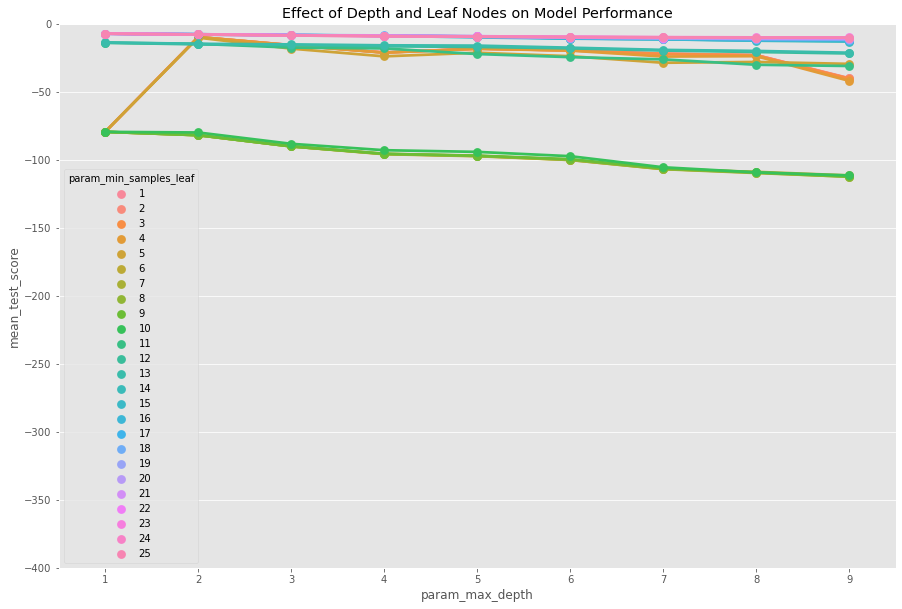

In [29]:
X_new=X_2.drop(['ISI','DC'], axis=1)
print(X_new.shape)
cv_sets = KFold(n_splits=10, shuffle= True,random_state=100)
param_grid = {
              "max_depth": [1,2,3,4,5,6,7,8,9],
              "min_samples_leaf":[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25],
              # "search_type": ["greedy", "grid", "adaptive"],
              # "n_search_grid": [50,100,200]
              }
grid = GridSearchCV(model_tree, param_grid,cv=cv_sets,n_jobs=4,scoring=error_metric)
try:
  X_new=X_new.to_numpy()
except:
  print('X is already numpy')

try:
  y=y.to_numpy()
except:
  print('y is already numpy')

grid = grid.fit(X_new,y)
print("Best Hyperparameters::\n{}".format(grid.best_estimator_))
lmt_t_2 = grid.best_estimator_
df = pd.DataFrame(data=grid.cv_results_)
fig,ax = plt.subplots(figsize=(15,10))
ax.set_ylim([-400,0])
sns.pointplot(data=df[['mean_test_score',
                           'param_min_samples_leaf',
                           'param_max_depth']],
             y='mean_test_score',x='param_max_depth',
             hue='param_min_samples_leaf',ax=ax)
ax.set(title="Effect of Depth and Leaf Nodes on Model Performance")

(468, 12)
mean absolute error: 6.906519673700979
SOC: 23


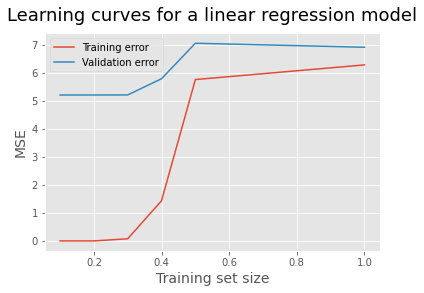

In [30]:
print(X.shape)
mae = cross_val_score(lmt_t_2,X_new,y,cv=cv_sets,scoring='neg_mean_absolute_error')
mae = np.abs(np.mean(mae))
print("mean absolute error: {}".format(mae))
soc=get_soc(lmt_t_2.max_depth,X_new.shape[1])
print("SOC: {}".format(soc))

train_sizes=np.array([0.1,0.2,0.3,0.4,0.5,1.0])
_,train_scores,validation_scores=learning_curve(lmt_t_2,X_new,y,cv=cv_sets,train_sizes=train_sizes,scoring=error_metric)
train_scores_mean = -train_scores.mean(axis = 1)
validation_scores_mean = -validation_scores.mean(axis = 1)

plt.title("Learning curve")

plt.plot(train_sizes, train_scores_mean, label = 'Training error')
plt.plot(train_sizes, validation_scores_mean, label = 'Validation error')
plt.legend()
plt.ylabel('MSE', fontsize = 14)
plt.xlabel('Training set size', fontsize = 14)
plt.title('Learning curves for a linear regression model', fontsize = 18, y = 1.03)
plt.legend()